In [1]:
!pip install transformers datasets sentencepiece --quiet

     |████████████████████████████████| 2.6 MB 8.1 MB/s 
     |████████████████████████████████| 264 kB 88.9 MB/s 
     |████████████████████████████████| 1.2 MB 79.0 MB/s 
     |████████████████████████████████| 636 kB 70.1 MB/s 
     |████████████████████████████████| 3.3 MB 62.3 MB/s 
     |████████████████████████████████| 895 kB 79.8 MB/s 
     |████████████████████████████████| 118 kB 89.8 MB/s 
     |████████████████████████████████| 76 kB 5.1 MB/s 
     |████████████████████████████████| 243 kB 71.2 MB/s 


In [2]:
import pandas as pd
import torch

In [3]:
import datasets

In [4]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

In [5]:
from bs4 import BeautifulSoup

In [6]:
from sklearn.model_selection import train_test_split

# The data

In [7]:
data = pd.read_excel('export-26-10-20.xlsx', engine='openpyxl')
print(data.shape)

(614, 26)


In [8]:
data.isnull().mean()

Article Name                 0.000000
PMID                         0.000000
Keywords                     0.700326
Date of Publication          0.003257
Abstract                     0.000000
Journal                      0.004886
Research Model               0.000000
Indication                   0.001629
MESH                         1.000000
Compound                     0.001629
Drug                         0.897394
Effect                       0.000000
Route of Administration      0.651466
Dose                         0.674267
Regimen                      0.926710
Side Effects                 0.907166
Minimum Age                  0.908795
Maximum Age                  0.918567
Gender                       0.824104
Ethnicity                    0.946254
Number of Patients           0.701954
Type of Clinical Trial       0.802932
Comorbidity                  0.871336
Drug Given in Combination    0.877850
Cell Line                    0.827362
Animal                       0.543974
dtype: float

In [9]:
data.dropna(subset={'Indication', 'Compound'}, inplace=True)
print(data.shape)

(612, 26)


In [10]:
def get_abstact_text(text):
    return BeautifulSoup(text).text

In [11]:
data.apply(lambda row: row.Indication.lower() in row.Abstract.lower(), axis=1).mean()

0.6405228758169934

In [12]:
data.apply(lambda row: row.Compound.lower() in row.Abstract.lower(), axis=1).mean()

0.8529411764705882

In [13]:
data.sample(3)

,Article Name,PMID,Keywords,Date of Publication,Abstract,Journal,Research Model,Indication,MESH,Compound,Drug,Effect,Route of Administration,Dose,Regimen,Side Effects,Minimum Age,Maximum Age,Gender,Ethnicity,Number of Patients,Type of Clinical Trial,Comorbidity,Drug Given in Combination,Cell Line,Animal
100,Drug-drug interaction between clobazam and can...,26114620,Antiepileptic drugs; Cannabis; Cytochrome P450...,2015.0,OBJECTIVE Under an expanded access investigati...,Epilepsia,clinical trial,Epilepsy,NaN,CBD,NaN,positive,NaN,5 mg/kg/day,NaN,"Ataxia, Drowsiness, Irritability, Tremor, Urin...",4.0,19.0,both,NaN,13.0,NaN,NaN,clobazam,NaN,NaN
115,"Safety, pharmacodynamics, and pharmacokinetics...",25752889,NaN,2015.0,"RATIONALE Data on safety, pharmacodynamics, an...",Psychopharmacology,clinical trial,Dementia,NaN,THC,NaN,SAFE,Oral (solution or capsules),"weeks 1-6, 0.75 mg; weeks 7-12, 1.5 mg",NaN,NaN,NaN,NaN,NaN,NaN,10.0,"randomized, double-blind, placebo-controlled, ...",NaN,NaN,NaN,NaN
142,How cannabis causes paranoia: using the intrav...,25031222,THC; cannabis; cognitive; delusions; paranoia,2015.0,Paranoia is receiving increasing attention in ...,Schizophrenia bulletin,clinical trial,Paranoia,NaN,THC,NaN,negative,Injected IV,1.5ml,Before tests,"Anxiety, Depression, Worry",21.0,50.0,NaN,NaN,121.0,"randomized, placebo-controlled",NaN,NaN,NaN,NaN


In [14]:
data['text_lhs'] = data.apply(lambda row: f'Compound: {row.Compound}; Indication: {row.Indication}', axis=1)
data['text_rhs'] = data.apply(lambda row: f'Title: {row["Article Name"]}\n{get_abstact_text(row.Abstract)}', axis=1)

In [15]:
data.text_lhs.value_counts().head(10)

Compound: THC; Indication: Pain                      30
Compound: CBD; Indication: Epilepsy                  26
Compound: CBD; Indication: Inflammation              24
Compound: CBD; Indication: Fear Anxiety PTSD         23
Compound: THC+CBD; Indication: Multiple sclerosis    20
Compound: THC; Indication: Nausea and vomiting       19
Compound: CBD; Indication: Schizophrenia             14
Compound: THC; Indication: Inflammation              14
Compound: THC; Indication: Fear Anxiety PTSD         13
Compound: THC; Indication: HIV viral infection       11
Name: text_lhs, dtype: int64

In [16]:
data.text_lhs.sample(5)

253                  Compound: THCV; Indication: Obesity
255                    Compound: CBD; Indication: Stress
85     Compound: THC+CBD; Indication: Autoimmune ence...
295       Compound: THC; Indication: Bacterial infection
583          Compound: THC; Indication: Anorexia nervosa
Name: text_lhs, dtype: object

In [18]:
print(data.text_rhs.sample(1).iloc[0])

Title: Concomitant THC and stress adolescent exposure induces impaired fear extinction and related neurobiological changes in adulthood.
Concomitant THC and stress adolescent exposure induces impaired fear extinction and related neurobiological changes in adulthood.. ?9-tetrahydrocannabinol (THC) consumption during adolescence is reported to be a risk factor for the appearance of psychiatric disorders later in life. The interaction between genetic or environmental events and cannabinoid exposure in the adolescent period can also contribute to exacerbate behavioural deficits in adulthood. Here we investigate the effects of THC treatment as well as the consequences of concomitant THC and stress exposure during adolescence in the extinction of fear memory in adult mice. Adolescent mice treated with THC and exposed to stress exhibit impaired cued fear extinction in adulthood. However, no effect was observed in animals exposed to these two factors separately. Notably, resistance to fear ext

In [19]:
data.Effect.value_counts()

positive    462
negative     84
NONE         54
SAFE         12
Name: Effect, dtype: int64

In [20]:
data_trainval, data_test = train_test_split(data, test_size=0.2, random_state=1)

In [21]:
data_train, data_val = train_test_split(data_trainval, test_size=0.2, random_state=1)

In [22]:
data_train.shape, data_val.shape, data_test.shape

((391, 28), (98, 28), (123, 28))

In [23]:
all_labels = sorted(set(data.Effect))
all_labels

['NONE', 'SAFE', 'negative', 'positive']

In [24]:
from datasets import Dataset, DatasetDict

In [25]:
dataset_dict = DatasetDict({
    k: Dataset.from_dict({
        'text1': v.text_lhs,
        'text2': v.text_rhs,
        'label': v.Effect.apply(lambda x: all_labels.index(x))
    })
    for k, v in zip(['train', 'val', 'test'], [data_train, data_val, data_test])
})

# The model

In [26]:
# a medical BERT from https://academic.oup.com/bioinformatics/article/36/4/1234/5566506
model_checkpoint = 'dmis-lab/biobert-base-cased-v1.2'
# a roberta-like model for longer texts, but without token_type_ids
# model_checkpoint = 'allenai/longformer-base-4096'
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)
model = AutoModelForSequenceClassification.from_pretrained(model_checkpoint, num_labels=len(all_labels))
if torch.cuda.is_available():
    model.cuda()

Downloading:   0%|          | 0.00/1.11k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/213k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/436M [00:00<?, ?B/s]

Some weights of the model checkpoint at dmis-lab/biobert-base-cased-v1.2 were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification we

In [27]:
from transformers import DataCollatorWithPadding
data_collator = DataCollatorWithPadding(tokenizer)

In [28]:
tokenizer('hello', 'world')

{'input_ids': [101, 19082, 102, 1362, 102], 'token_type_ids': [0, 0, 0, 1, 1], 'attention_mask': [1, 1, 1, 1, 1]}

In [29]:
def tokenize(x):
    return tokenizer(x["text1"], x['text2'], truncation=True, padding=True)

dataset_dict_tokenized = dataset_dict.map(tokenize, batched=True)

pd.Series(
    [len([tok for tok in text if tok != tokenizer.pad_token_id]) for text in dataset_dict_tokenized['train']['input_ids']]
).quantile([0.5, 0.8, 0.9, 0.95, 0.99, 1])

  0%|          | 0/1 [00:00<?, ?ba/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

0.50     466.0
0.80     562.0
0.90     604.0
0.95     653.5
0.99     912.5
1.00    1104.0
dtype: float64

Most of the texts fit into 512 tokens, but for longer texts we might need to fine tune a longformer instead of a BERT

In [30]:
def tokenize(x):
    return tokenizer(x["text1"], x['text2'], truncation=True, padding=True, max_length=model.config.max_position_embeddings)

dataset_dict_tokenized = dataset_dict.map(tokenize, batched=True)

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

In [31]:
from torch.utils.data import DataLoader

In [32]:
batch_size = 16  # maximum size for colab 

loaders = {
    k : DataLoader(
        v.remove_columns(['text1', 'text2']), 
        batch_size=batch_size, 
        drop_last=False, 
        shuffle=True, 
        num_workers=1, 
        collate_fn=data_collator
    )
    for k, v in dataset_dict_tokenized.items()
}

In [33]:
from tqdm.auto import tqdm, trange
import numpy as np
from sklearn.metrics import precision_recall_fscore_support, roc_auc_score

In [34]:
def batched_predict(model, dev_dataloader):
    preds = []
    facts = []

    for batch in tqdm(dev_dataloader):
        facts.append(batch.labels.cpu().numpy())
        batch = batch.to(model.device)
        with torch.no_grad():
            pr = model(input_ids=batch.input_ids, attention_mask=batch.attention_mask, token_type_ids=batch.token_type_ids)
        preds.append(torch.softmax(pr.logits, -1).cpu().numpy())
    facts = np.concatenate(facts)
    preds = np.concatenate(preds)
    return facts, preds

In [35]:
def evaluate_model(model, dev_dataloader):
    facts, preds = batched_predict(model, dev_dataloader)

    p, r, f, s = precision_recall_fscore_support(facts, preds.argmax(axis=1), zero_division=0)
    results = {f'recall_{k}': v for k, v in zip(all_labels, r)}
    results['macro_recall'] = r.mean()
    results['macro_f'] = f.mean()
    results['accuracy'] = (facts == preds.argmax(axis=1)).mean()

    return results

model.eval()
print(evaluate_model(model, loaders['val']))

  0%|          | 0/7 [00:00<?, ?it/s]

{'recall_NONE': 0.125, 'recall_SAFE': 0.0, 'recall_negative': 0.6470588235294118, 'recall_positive': 0.02857142857142857, 'macro_recall': 0.2001575630252101, 'macro_f': 0.09541390395820777, 'accuracy': 0.14285714285714285}


In [36]:
import gc

def cleanup():
    gc.collect()
    torch.cuda.empty_cache()
    
cleanup()

Замораживаем трансформерные слои, кроме последних трёх. Вроде как это может помочь меньше переобучаться. 

In [37]:
model.requires_grad_(True)
print(len([p for p in model.parameters() if p.requires_grad]))
model.bert.requires_grad_(False);
print(len([p for p in model.parameters() if p.requires_grad]))
model.bert.pooler.requires_grad_(True);
print(len([p for p in model.parameters() if p.requires_grad]))
model.bert.embeddings.requires_grad_(True)
print(len([p for p in model.parameters() if p.requires_grad]))
for layer in model.bert.encoder.layer[-3:]:
    layer.requires_grad_(True);
print(len([p for p in model.parameters() if p.requires_grad]))

201
2
4
9
57


In [38]:
optimizer = torch.optim.Adam(params=[p for p in model.parameters() if p.requires_grad], lr=1e-4)

In [39]:
gradient_accumulation_steps = max(1, int(128 / batch_size))
print(gradient_accumulation_steps)
window = 100
cleanup_step = 50
report_step = 500

8


In [40]:
for batch in loaders['train']:
    break
print(batch.keys())

dict_keys(['attention_mask', 'input_ids', 'token_type_ids', 'labels'])


In [41]:
ewm_loss = 0
model.train()
cleanup()

for epoch in trange(15):
    tq = tqdm(loaders['train'])
    
    for i, batch in enumerate(tq):
        
        if i % report_step == 0:
            model.eval()
            eval_loss = evaluate_model(model, loaders['val'])
            model.train()
            print(f'epoch {epoch}, step {i}: train loss: {ewm_loss:4.4f}  val auc: {eval_loss}')
            cleanup()
        
        try:
            batch = batch.to(model.device)
            output = model(**batch)
            loss = output.loss
            loss.backward()
        except RuntimeError as e:
            print('error on step', i, e)
            loss = None
            cleanup()
            continue

        if i and i % gradient_accumulation_steps == 0:
            optimizer.step()
            optimizer.zero_grad()
            
        if i % cleanup_step == 0:
            cleanup()

        w = 1 / min(i+1, window)
        ewm_loss = ewm_loss * (1-w) + loss.item() * w
        tq.set_description(f'loss: {ewm_loss:4.4f}')


  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

epoch 0, step 0: train loss: 0.0000  val auc: {'recall_NONE': 0.125, 'recall_SAFE': 0.0, 'recall_negative': 0.6470588235294118, 'recall_positive': 0.02857142857142857, 'macro_recall': 0.2001575630252101, 'macro_f': 0.09541390395820777, 'accuracy': 0.14285714285714285}


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

epoch 1, step 0: train loss: 1.1197  val auc: {'recall_NONE': 0.0, 'recall_SAFE': 0.0, 'recall_negative': 0.0, 'recall_positive': 1.0, 'macro_recall': 0.25, 'macro_f': 0.20833333333333331, 'accuracy': 0.7142857142857143}


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

epoch 2, step 0: train loss: 0.8058  val auc: {'recall_NONE': 0.0, 'recall_SAFE': 0.0, 'recall_negative': 0.0, 'recall_positive': 1.0, 'macro_recall': 0.25, 'macro_f': 0.20833333333333331, 'accuracy': 0.7142857142857143}


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

epoch 3, step 0: train loss: 0.7931  val auc: {'recall_NONE': 0.0, 'recall_SAFE': 0.0, 'recall_negative': 0.0, 'recall_positive': 1.0, 'macro_recall': 0.25, 'macro_f': 0.20833333333333331, 'accuracy': 0.7142857142857143}


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

epoch 4, step 0: train loss: 0.7498  val auc: {'recall_NONE': 0.0, 'recall_SAFE': 0.0, 'recall_negative': 0.0, 'recall_positive': 1.0, 'macro_recall': 0.25, 'macro_f': 0.20833333333333331, 'accuracy': 0.7142857142857143}


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

epoch 5, step 0: train loss: 0.7448  val auc: {'recall_NONE': 0.0, 'recall_SAFE': 0.0, 'recall_negative': 0.0, 'recall_positive': 1.0, 'macro_recall': 0.25, 'macro_f': 0.20833333333333331, 'accuracy': 0.7142857142857143}


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

epoch 6, step 0: train loss: 0.6990  val auc: {'recall_NONE': 0.0, 'recall_SAFE': 0.0, 'recall_negative': 0.0, 'recall_positive': 1.0, 'macro_recall': 0.25, 'macro_f': 0.20833333333333331, 'accuracy': 0.7142857142857143}


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

epoch 7, step 0: train loss: 0.6624  val auc: {'recall_NONE': 0.0, 'recall_SAFE': 0.0, 'recall_negative': 0.11764705882352941, 'recall_positive': 0.9857142857142858, 'macro_recall': 0.2758403361344538, 'macro_f': 0.2579849012775842, 'accuracy': 0.7244897959183674}


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

epoch 8, step 0: train loss: 0.5959  val auc: {'recall_NONE': 0.0, 'recall_SAFE': 0.0, 'recall_negative': 0.11764705882352941, 'recall_positive': 1.0, 'macro_recall': 0.27941176470588236, 'macro_f': 0.2621212121212121, 'accuracy': 0.7346938775510204}


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

epoch 9, step 0: train loss: 0.5693  val auc: {'recall_NONE': 0.0, 'recall_SAFE': 0.0, 'recall_negative': 0.7647058823529411, 'recall_positive': 0.9142857142857143, 'macro_recall': 0.4197478991596638, 'macro_f': 0.3807588075880759, 'accuracy': 0.7857142857142857}


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

epoch 10, step 0: train loss: 0.5069  val auc: {'recall_NONE': 0.0, 'recall_SAFE': 0.0, 'recall_negative': 0.23529411764705882, 'recall_positive': 1.0, 'macro_recall': 0.3088235294117647, 'macro_f': 0.3069584736251403, 'accuracy': 0.7551020408163265}


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

epoch 11, step 0: train loss: 0.4510  val auc: {'recall_NONE': 0.375, 'recall_SAFE': 0.0, 'recall_negative': 0.7058823529411765, 'recall_positive': 0.9, 'macro_recall': 0.49522058823529413, 'macro_f': 0.4841698055583834, 'accuracy': 0.7959183673469388}


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

epoch 12, step 0: train loss: 0.3999  val auc: {'recall_NONE': 0.0, 'recall_SAFE': 0.3333333333333333, 'recall_negative': 0.29411764705882354, 'recall_positive': 0.9714285714285714, 'macro_recall': 0.3997198879551821, 'macro_f': 0.4012820512820513, 'accuracy': 0.7551020408163265}


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

epoch 13, step 0: train loss: 0.3629  val auc: {'recall_NONE': 0.125, 'recall_SAFE': 0.3333333333333333, 'recall_negative': 0.6470588235294118, 'recall_positive': 0.8857142857142857, 'macro_recall': 0.4977766106442577, 'macro_f': 0.48930946152169175, 'accuracy': 0.7653061224489796}


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

epoch 14, step 0: train loss: 0.3017  val auc: {'recall_NONE': 0.0, 'recall_SAFE': 0.3333333333333333, 'recall_negative': 0.35294117647058826, 'recall_positive': 0.9714285714285714, 'macro_recall': 0.4144257703081232, 'macro_f': 0.41807278742762616, 'accuracy': 0.7653061224489796}


Полная модель за 15 эпох c шагом 1e-5 не успевает запомнить обучающую выборку,  

train data:
```
{'recall_NONE': 0.0, 'recall_SAFE': 0.875, 'recall_negative': 0.9622641509433962, 'recall_positive': 0.9863481228668942, 'macro_recall': 0.7059030684525727, 'macro_f': 0.6412634519138137, 'accuracy': 0.887468030690537}
```

validation data:
```
{'recall_NONE': 0.0, 'recall_SAFE': 0.3333333333333333, 'recall_negative': 0.5294117647058824, 'recall_positive': 0.8857142857142857, 'macro_recall': 0.43711484593837535, 'macro_f': 0.4322141560798548, 'accuracy': 0.7346938775510204}
```

Если увеличить скорость обучения до 1e-4, мы только оверфитимся:

```
train
{'recall_NONE': 0.9459459459459459, 'recall_SAFE': 0.75, 'recall_negative': 0.9433962264150944, 'recall_positive': 0.9897610921501706, 'macro_recall': 0.9072758161278027, 'macro_f': 0.9287041804696744, 'accuracy': 0.9744245524296675}
val
'recall_NONE': 0.125, 'recall_SAFE': 0.0, 'recall_negative': 0.47058823529411764, 'recall_positive': 0.8428571428571429, 'macro_recall': 0.3596113445378151, 'macro_f': 0.35904095904095906, 'accuracy': 0.6938775510204082}
```

In [42]:
model.eval()
train_loss = evaluate_model(model, loaders['train'])
print(train_loss)

  0%|          | 0/25 [00:00<?, ?it/s]

{'recall_NONE': 0.6756756756756757, 'recall_SAFE': 0.875, 'recall_negative': 0.8490566037735849, 'recall_positive': 0.9761092150170648, 'macro_recall': 0.8439603736165813, 'macro_f': 0.8071279234355319, 'accuracy': 0.928388746803069}


In [43]:
model.eval()
eval_loss = evaluate_model(model, loaders['val'])
print(eval_loss)

  0%|          | 0/7 [00:00<?, ?it/s]

{'recall_NONE': 0.25, 'recall_SAFE': 0.3333333333333333, 'recall_negative': 0.5294117647058824, 'recall_positive': 0.9142857142857143, 'macro_recall': 0.5067577030812325, 'macro_f': 0.5367261591148578, 'accuracy': 0.7755102040816326}


Поучим ещё 15 эпох, разморозив модель и уменьшив скорость обучения

In [44]:
model.requires_grad_(True);

In [45]:
optimizer = torch.optim.Adam(params=[p for p in model.parameters() if p.requires_grad], lr=1e-5)

In [46]:
ewm_loss = 0
model.train()
cleanup()

for epoch in trange(45):
    tq = tqdm(loaders['train'])
    
    for i, batch in enumerate(tq):
        
        if i % report_step == 0:
            model.eval()
            eval_loss = evaluate_model(model, loaders['val'])
            model.train()
            print(f'epoch {epoch}, step {i}: train loss: {ewm_loss:4.4f}  val auc: {eval_loss}')
            cleanup()
        
        try:
            batch = batch.to(model.device)
            output = model(**batch)
            loss = output.loss
            loss.backward()
        except RuntimeError as e:
            print('error on step', i, e)
            loss = None
            cleanup()
            continue

        if i and i % gradient_accumulation_steps == 0:
            optimizer.step()
            optimizer.zero_grad()
            
        if i % cleanup_step == 0:
            cleanup()

        w = 1 / min(i+1, window)
        ewm_loss = ewm_loss * (1-w) + loss.item() * w
        tq.set_description(f'loss: {ewm_loss:4.4f}')


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

epoch 0, step 0: train loss: 0.0000  val auc: {'recall_NONE': 0.25, 'recall_SAFE': 0.3333333333333333, 'recall_negative': 0.5294117647058824, 'recall_positive': 0.9142857142857143, 'macro_recall': 0.5067577030812325, 'macro_f': 0.5367261591148578, 'accuracy': 0.7755102040816326}


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

epoch 1, step 0: train loss: 0.2879  val auc: {'recall_NONE': 0.0, 'recall_SAFE': 0.3333333333333333, 'recall_negative': 0.35294117647058826, 'recall_positive': 0.9714285714285714, 'macro_recall': 0.4144257703081232, 'macro_f': 0.43333333333333335, 'accuracy': 0.7653061224489796}


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

epoch 2, step 0: train loss: 0.2162  val auc: {'recall_NONE': 0.25, 'recall_SAFE': 0.3333333333333333, 'recall_negative': 0.7058823529411765, 'recall_positive': 0.8714285714285714, 'macro_recall': 0.5401610644257703, 'macro_f': 0.5501936912008855, 'accuracy': 0.7755102040816326}


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

epoch 3, step 0: train loss: 0.2088  val auc: {'recall_NONE': 0.0, 'recall_SAFE': 0.3333333333333333, 'recall_negative': 0.5294117647058824, 'recall_positive': 0.9428571428571428, 'macro_recall': 0.45140056022408964, 'macro_f': 0.46370433668019656, 'accuracy': 0.7755102040816326}


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

epoch 4, step 0: train loss: 0.2441  val auc: {'recall_NONE': 0.0, 'recall_SAFE': 0.3333333333333333, 'recall_negative': 0.5294117647058824, 'recall_positive': 0.9714285714285714, 'macro_recall': 0.4585434173669468, 'macro_f': 0.4773946360153257, 'accuracy': 0.7959183673469388}


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

epoch 5, step 0: train loss: 0.1888  val auc: {'recall_NONE': 0.25, 'recall_SAFE': 0.3333333333333333, 'recall_negative': 0.5882352941176471, 'recall_positive': 0.9285714285714286, 'macro_recall': 0.5250350140056022, 'macro_f': 0.5557758166491044, 'accuracy': 0.7959183673469388}


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

epoch 6, step 0: train loss: 0.1923  val auc: {'recall_NONE': 0.25, 'recall_SAFE': 0.3333333333333333, 'recall_negative': 0.5882352941176471, 'recall_positive': 0.9142857142857143, 'macro_recall': 0.5214635854341736, 'macro_f': 0.5491278836106422, 'accuracy': 0.7857142857142857}


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

epoch 7, step 0: train loss: 0.1745  val auc: {'recall_NONE': 0.25, 'recall_SAFE': 0.3333333333333333, 'recall_negative': 0.5882352941176471, 'recall_positive': 0.9285714285714286, 'macro_recall': 0.5250350140056022, 'macro_f': 0.5557758166491044, 'accuracy': 0.7959183673469388}


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

epoch 8, step 0: train loss: 0.1584  val auc: {'recall_NONE': 0.25, 'recall_SAFE': 0.3333333333333333, 'recall_negative': 0.5294117647058824, 'recall_positive': 0.9571428571428572, 'macro_recall': 0.5174719887955183, 'macro_f': 0.558165548098434, 'accuracy': 0.8061224489795918}


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

epoch 9, step 0: train loss: 0.1748  val auc: {'recall_NONE': 0.25, 'recall_SAFE': 0.3333333333333333, 'recall_negative': 0.5294117647058824, 'recall_positive': 0.9571428571428572, 'macro_recall': 0.5174719887955183, 'macro_f': 0.558165548098434, 'accuracy': 0.8061224489795918}


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

epoch 10, step 0: train loss: 0.1497  val auc: {'recall_NONE': 0.25, 'recall_SAFE': 0.3333333333333333, 'recall_negative': 0.5882352941176471, 'recall_positive': 0.9285714285714286, 'macro_recall': 0.5250350140056022, 'macro_f': 0.5557758166491044, 'accuracy': 0.7959183673469388}


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

epoch 11, step 0: train loss: 0.1414  val auc: {'recall_NONE': 0.25, 'recall_SAFE': 0.3333333333333333, 'recall_negative': 0.5294117647058824, 'recall_positive': 0.9285714285714286, 'macro_recall': 0.510329131652661, 'macro_f': 0.5431728026198073, 'accuracy': 0.7857142857142857}


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

epoch 12, step 0: train loss: 0.1354  val auc: {'recall_NONE': 0.25, 'recall_SAFE': 0.3333333333333333, 'recall_negative': 0.5294117647058824, 'recall_positive': 0.9571428571428572, 'macro_recall': 0.5174719887955183, 'macro_f': 0.558165548098434, 'accuracy': 0.8061224489795918}


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

epoch 13, step 0: train loss: 0.1304  val auc: {'recall_NONE': 0.0, 'recall_SAFE': 0.3333333333333333, 'recall_negative': 0.5294117647058824, 'recall_positive': 0.9571428571428572, 'macro_recall': 0.45497198879551826, 'macro_f': 0.4670155949583423, 'accuracy': 0.7857142857142857}


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

epoch 14, step 0: train loss: 0.1136  val auc: {'recall_NONE': 0.125, 'recall_SAFE': 0.3333333333333333, 'recall_negative': 0.5294117647058824, 'recall_positive': 0.9571428571428572, 'macro_recall': 0.48622198879551826, 'macro_f': 0.5154480505422268, 'accuracy': 0.7959183673469388}


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

epoch 15, step 0: train loss: 0.1207  val auc: {'recall_NONE': 0.125, 'recall_SAFE': 0.3333333333333333, 'recall_negative': 0.5882352941176471, 'recall_positive': 0.9285714285714286, 'macro_recall': 0.49378501400560226, 'macro_f': 0.5157845579078456, 'accuracy': 0.7857142857142857}


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

epoch 16, step 0: train loss: 0.1103  val auc: {'recall_NONE': 0.125, 'recall_SAFE': 0.3333333333333333, 'recall_negative': 0.5882352941176471, 'recall_positive': 0.9285714285714286, 'macro_recall': 0.49378501400560226, 'macro_f': 0.5157845579078456, 'accuracy': 0.7857142857142857}


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

epoch 17, step 0: train loss: 0.0996  val auc: {'recall_NONE': 0.0, 'recall_SAFE': 0.3333333333333333, 'recall_negative': 0.47058823529411764, 'recall_positive': 0.9571428571428572, 'macro_recall': 0.440266106442577, 'macro_f': 0.4537280701754386, 'accuracy': 0.7755102040816326}


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

epoch 18, step 0: train loss: 0.1024  val auc: {'recall_NONE': 0.0, 'recall_SAFE': 0.3333333333333333, 'recall_negative': 0.47058823529411764, 'recall_positive': 0.9571428571428572, 'macro_recall': 0.440266106442577, 'macro_f': 0.4537280701754386, 'accuracy': 0.7755102040816326}


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

epoch 19, step 0: train loss: 0.0828  val auc: {'recall_NONE': 0.25, 'recall_SAFE': 0.3333333333333333, 'recall_negative': 0.5882352941176471, 'recall_positive': 0.9285714285714286, 'macro_recall': 0.5250350140056022, 'macro_f': 0.5557758166491044, 'accuracy': 0.7959183673469388}


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

epoch 20, step 0: train loss: 0.0852  val auc: {'recall_NONE': 0.125, 'recall_SAFE': 0.3333333333333333, 'recall_negative': 0.5882352941176471, 'recall_positive': 0.9285714285714286, 'macro_recall': 0.49378501400560226, 'macro_f': 0.5157845579078456, 'accuracy': 0.7857142857142857}


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

epoch 21, step 0: train loss: 0.0831  val auc: {'recall_NONE': 0.125, 'recall_SAFE': 0.3333333333333333, 'recall_negative': 0.5882352941176471, 'recall_positive': 0.9285714285714286, 'macro_recall': 0.49378501400560226, 'macro_f': 0.5157845579078456, 'accuracy': 0.7857142857142857}


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

epoch 22, step 0: train loss: 0.0814  val auc: {'recall_NONE': 0.0, 'recall_SAFE': 0.3333333333333333, 'recall_negative': 0.5294117647058824, 'recall_positive': 0.9571428571428572, 'macro_recall': 0.45497198879551826, 'macro_f': 0.4670155949583423, 'accuracy': 0.7857142857142857}


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

epoch 23, step 0: train loss: 0.0816  val auc: {'recall_NONE': 0.0, 'recall_SAFE': 0.3333333333333333, 'recall_negative': 0.47058823529411764, 'recall_positive': 0.9571428571428572, 'macro_recall': 0.440266106442577, 'macro_f': 0.4537280701754386, 'accuracy': 0.7755102040816326}


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

epoch 24, step 0: train loss: 0.0770  val auc: {'recall_NONE': 0.125, 'recall_SAFE': 0.3333333333333333, 'recall_negative': 0.5882352941176471, 'recall_positive': 0.9571428571428572, 'macro_recall': 0.5009278711484594, 'macro_f': 0.5315770828002913, 'accuracy': 0.8061224489795918}


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

epoch 25, step 0: train loss: 0.0761  val auc: {'recall_NONE': 0.125, 'recall_SAFE': 0.3333333333333333, 'recall_negative': 0.5882352941176471, 'recall_positive': 0.9428571428571428, 'macro_recall': 0.4973564425770308, 'macro_f': 0.5214594928880644, 'accuracy': 0.7959183673469388}


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

epoch 26, step 0: train loss: 0.0686  val auc: {'recall_NONE': 0.0, 'recall_SAFE': 0.3333333333333333, 'recall_negative': 0.47058823529411764, 'recall_positive': 0.9571428571428572, 'macro_recall': 0.440266106442577, 'macro_f': 0.45518763796909495, 'accuracy': 0.7755102040816326}


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

epoch 27, step 0: train loss: 0.0575  val auc: {'recall_NONE': 0.0, 'recall_SAFE': 0.3333333333333333, 'recall_negative': 0.47058823529411764, 'recall_positive': 0.9571428571428572, 'macro_recall': 0.440266106442577, 'macro_f': 0.4537280701754386, 'accuracy': 0.7755102040816326}


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

epoch 28, step 0: train loss: 0.0609  val auc: {'recall_NONE': 0.0, 'recall_SAFE': 0.3333333333333333, 'recall_negative': 0.47058823529411764, 'recall_positive': 0.9571428571428572, 'macro_recall': 0.440266106442577, 'macro_f': 0.4537280701754386, 'accuracy': 0.7755102040816326}


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

epoch 29, step 0: train loss: 0.0533  val auc: {'recall_NONE': 0.0, 'recall_SAFE': 0.3333333333333333, 'recall_negative': 0.5294117647058824, 'recall_positive': 0.9571428571428572, 'macro_recall': 0.45497198879551826, 'macro_f': 0.4670155949583423, 'accuracy': 0.7857142857142857}


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

epoch 30, step 0: train loss: 0.0606  val auc: {'recall_NONE': 0.0, 'recall_SAFE': 0.3333333333333333, 'recall_negative': 0.5882352941176471, 'recall_positive': 0.9428571428571428, 'macro_recall': 0.4661064425770308, 'macro_f': 0.47154861944777915, 'accuracy': 0.7857142857142857}


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

epoch 31, step 0: train loss: 0.0511  val auc: {'recall_NONE': 0.0, 'recall_SAFE': 0.3333333333333333, 'recall_negative': 0.6470588235294118, 'recall_positive': 0.9428571428571428, 'macro_recall': 0.480812324929972, 'macro_f': 0.48317025440313116, 'accuracy': 0.7959183673469388}


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

epoch 32, step 0: train loss: 0.0545  val auc: {'recall_NONE': 0.0, 'recall_SAFE': 0.3333333333333333, 'recall_negative': 0.5882352941176471, 'recall_positive': 0.9428571428571428, 'macro_recall': 0.4661064425770308, 'macro_f': 0.4744881244881245, 'accuracy': 0.7857142857142857}


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

epoch 33, step 0: train loss: 0.0594  val auc: {'recall_NONE': 0.125, 'recall_SAFE': 0.3333333333333333, 'recall_negative': 0.47058823529411764, 'recall_positive': 0.9571428571428572, 'macro_recall': 0.471516106442577, 'macro_f': 0.5083257713248639, 'accuracy': 0.7857142857142857}


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

epoch 34, step 0: train loss: 0.0511  val auc: {'recall_NONE': 0.125, 'recall_SAFE': 0.3333333333333333, 'recall_negative': 0.47058823529411764, 'recall_positive': 0.9571428571428572, 'macro_recall': 0.471516106442577, 'macro_f': 0.5083257713248639, 'accuracy': 0.7857142857142857}


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

epoch 35, step 0: train loss: 0.0497  val auc: {'recall_NONE': 0.125, 'recall_SAFE': 0.3333333333333333, 'recall_negative': 0.47058823529411764, 'recall_positive': 0.9428571428571428, 'macro_recall': 0.46794467787114846, 'macro_f': 0.50192862629492, 'accuracy': 0.7755102040816326}


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

epoch 36, step 0: train loss: 0.0532  val auc: {'recall_NONE': 0.125, 'recall_SAFE': 0.3333333333333333, 'recall_negative': 0.5294117647058824, 'recall_positive': 0.9285714285714286, 'macro_recall': 0.4790791316526611, 'macro_f': 0.5033801020408163, 'accuracy': 0.7755102040816326}


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

epoch 37, step 0: train loss: 0.0476  val auc: {'recall_NONE': 0.125, 'recall_SAFE': 0.3333333333333333, 'recall_negative': 0.5882352941176471, 'recall_positive': 0.9285714285714286, 'macro_recall': 0.49378501400560226, 'macro_f': 0.5157845579078456, 'accuracy': 0.7857142857142857}


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

epoch 38, step 0: train loss: 0.0468  val auc: {'recall_NONE': 0.0, 'recall_SAFE': 0.3333333333333333, 'recall_negative': 0.5882352941176471, 'recall_positive': 0.9428571428571428, 'macro_recall': 0.4661064425770308, 'macro_f': 0.4729916615822656, 'accuracy': 0.7857142857142857}


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

epoch 39, step 0: train loss: 0.0496  val auc: {'recall_NONE': 0.0, 'recall_SAFE': 0.3333333333333333, 'recall_negative': 0.5294117647058824, 'recall_positive': 0.9428571428571428, 'macro_recall': 0.45140056022408964, 'macro_f': 0.460625, 'accuracy': 0.7755102040816326}


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

epoch 40, step 0: train loss: 0.0469  val auc: {'recall_NONE': 0.125, 'recall_SAFE': 0.3333333333333333, 'recall_negative': 0.5294117647058824, 'recall_positive': 0.9571428571428572, 'macro_recall': 0.48622198879551826, 'macro_f': 0.5218543046357615, 'accuracy': 0.7959183673469388}


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

epoch 41, step 0: train loss: 0.0434  val auc: {'recall_NONE': 0.125, 'recall_SAFE': 0.3333333333333333, 'recall_negative': 0.5294117647058824, 'recall_positive': 0.9571428571428572, 'macro_recall': 0.48622198879551826, 'macro_f': 0.5187878787878788, 'accuracy': 0.7959183673469388}


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

epoch 42, step 0: train loss: 0.0439  val auc: {'recall_NONE': 0.125, 'recall_SAFE': 0.3333333333333333, 'recall_negative': 0.47058823529411764, 'recall_positive': 0.9571428571428572, 'macro_recall': 0.471516106442577, 'macro_f': 0.5083257713248639, 'accuracy': 0.7857142857142857}


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

epoch 43, step 0: train loss: 0.0452  val auc: {'recall_NONE': 0.125, 'recall_SAFE': 0.3333333333333333, 'recall_negative': 0.5294117647058824, 'recall_positive': 0.9571428571428572, 'macro_recall': 0.48622198879551826, 'macro_f': 0.5218543046357615, 'accuracy': 0.7959183673469388}


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

epoch 44, step 0: train loss: 0.0393  val auc: {'recall_NONE': 0.125, 'recall_SAFE': 0.3333333333333333, 'recall_negative': 0.5294117647058824, 'recall_positive': 0.9428571428571428, 'macro_recall': 0.48265056022408964, 'macro_f': 0.5120923458442402, 'accuracy': 0.7857142857142857}


После ещё 15 эпох можешь уже неплохо выучивает обучающую выборку, но всё ещё очень плоха на валидационной

```
{'recall_NONE': 0.9459459459459459, 'recall_SAFE': 1.0, 'recall_negative': 0.9056603773584906, 'recall_positive': 1.0, 'macro_recall': 0.9629015808261092, 'macro_f': 0.9478770967414829, 'accuracy': 0.9820971867007673}

{'recall_NONE': 0.25, 'recall_SAFE': 0.3333333333333333, 'recall_negative': 0.5882352941176471, 'recall_positive': 0.9571428571428572, 'macro_recall': 0.5321778711484594, 'macro_f': 0.5709750072653298, 'accuracy': 0.8163265306122449}
```

Если я размораживаю все слои и уменьшаю LR до 1e-5 на втором шаге, получаю модель чуть менее переобученную после 15 эпох. 
```
{'recall_NONE': 0.8648648648648649, 'recall_SAFE': 0.875, 'recall_negative': 0.9811320754716981, 'recall_positive': 0.9863481228668942, 'macro_recall': 0.9268362658008642, 'macro_f': 0.9144525563227006, 'accuracy': 0.9718670076726342}

{'recall_NONE': 0.25, 'recall_SAFE': 0.3333333333333333, 'recall_negative': 0.5882352941176471, 'recall_positive': 0.9285714285714286, 'macro_recall': 0.5250350140056022, 'macro_f': 0.5525761594727112, 'accuracy': 0.7959183673469388}
```

Если в таком режиме пофайнтюнить целых 45 эпох (всего 45: 15 с замороженными слоями + 30 полностью), на обучающей выборке качество растёт, а на тестовой уже кажется оверфит. 

```
{'recall_NONE': 1.0, 'recall_SAFE': 1.0, 'recall_negative': 0.9433962264150944, 'recall_positive': 0.9897610921501706, 'macro_recall': 0.9832893296413163, 'macro_f': 0.9615717708115045, 'accuracy': 0.9846547314578005}

{'recall_NONE': 0.125, 'recall_SAFE': 0.3333333333333333, 'recall_negative': 0.5294117647058824, 'recall_positive': 0.9285714285714286, 'macro_recall': 0.4790791316526611, 'macro_f': 0.506422551583842, 'accuracy': 0.7755102040816326}
```

In [47]:
cleanup()

In [49]:
model_name = 'bert-effect-classifier-20210731'

model.save_pretrained(model_name)
tokenizer.save_pretrained(model_name)

('bert-effect-classifier-20210731/tokenizer_config.json',
 'bert-effect-classifier-20210731/special_tokens_map.json',
 'bert-effect-classifier-20210731/vocab.txt',
 'bert-effect-classifier-20210731/added_tokens.json',
 'bert-effect-classifier-20210731/tokenizer.json')

In [50]:
model.eval()
train_loss = evaluate_model(model, loaders['train'])
print(train_loss)
eval_loss = evaluate_model(model, loaders['val'])
print(eval_loss)

  0%|          | 0/25 [00:00<?, ?it/s]

{'recall_NONE': 1.0, 'recall_SAFE': 1.0, 'recall_negative': 0.9433962264150944, 'recall_positive': 0.9897610921501706, 'macro_recall': 0.9832893296413163, 'macro_f': 0.9615717708115045, 'accuracy': 0.9846547314578005}


  0%|          | 0/7 [00:00<?, ?it/s]

{'recall_NONE': 0.125, 'recall_SAFE': 0.3333333333333333, 'recall_negative': 0.5294117647058824, 'recall_positive': 0.9285714285714286, 'macro_recall': 0.4790791316526611, 'macro_f': 0.506422551583842, 'accuracy': 0.7755102040816326}


In [51]:
cleanup()

In [52]:
facts, preds = batched_predict(model, loaders['val'])

  0%|          | 0/7 [00:00<?, ?it/s]

In [53]:
pd.DataFrame(preds).describe()

,0,1,2,3
count,98.000000,98.000000,98.000000,98.000000
mean,0.033447,0.020768,0.149505,0.796280
std,0.135489,0.134365,0.321209,0.366738
min,0.000298,0.000100,0.000323,0.002356
25%,0.000448,0.000238,0.000738,0.907039
50%,0.000897,0.000332,0.001653,0.997104
75%,0.006703,0.001030,0.031724,0.998411
max,0.949904,0.961093,0.981618,0.999118


ROC AUC by class was in the first setting:

```
0.7694444444444444
0.7894736842105263
0.860566448801743
0.8525510204081633
```

with longer and slower fine-tuning it is
```
0.7555555555555556
0.8035087719298246
0.8765432098765432
0.8785714285714286
```

In [54]:
for i in range(4):
    print(roc_auc_score(facts==i, preds[:, i]))    

0.7555555555555556
0.8035087719298246
0.8765432098765432
0.8785714285714286


Previous results are (on another train/test split) the following:

so the current model is not so bad (although it can be much, much better).

In [55]:
print('positive recall', 80 / (80+3+7))
print('negative recall', 19 / (12+19+7))
print('none     recall', 19 / (7 +4+19))

print('accuracy', (80 + 19 + 19) / ((80+3+7) + (12+19+7) + (7 +4+19)))

positive recall 0.8888888888888888
negative recall 0.5
none     recall 0.6333333333333333
accuracy 0.7468354430379747


Энтропия предсказанного распределения - мера неопределённости. Чем больше она, тем модель чаще ошибается. 

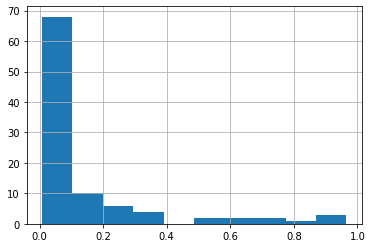

In [168]:
entropy = pd.Series(-(np.log(preds) * preds).sum(1))
entropy.hist();

In [169]:
pd.Series(preds.argmax(1)==facts).groupby(pd.qcut(entropy, 5)).aggregate([len, np.mean])

,len,mean
"(0.006979999999999999, 0.0127]",20,0.950000
"(0.0127, 0.0169]",19,0.947368
"(0.0169, 0.0353]",20,0.900000
"(0.0353, 0.21]",19,0.684211
"(0.21, 0.965]",20,0.400000


In [227]:
!zip -r bert-effect-classifier-20210731.zip bert-effect-classifier-20210731

  adding: bert-effect-classifier-20210731/ (stored 0%)
  adding: bert-effect-classifier-20210731/vocab.txt (deflated 49%)
  adding: bert-effect-classifier-20210731/special_tokens_map.json (deflated 40%)
  adding: bert-effect-classifier-20210731/pytorch_model.bin (deflated 7%)
  adding: bert-effect-classifier-20210731/config.json (deflated 51%)
  adding: bert-effect-classifier-20210731/tokenizer_config.json (deflated 42%)
  adding: bert-effect-classifier-20210731/tokenizer.json (deflated 57%)


# Сбор выборки на разметку

Задача - разметить 1000 новых наблюдений, с соблюдением следующих критериев:

1. Должно быть размечено довольно много статей с каждым из 4 эффектов (хотя бы по 150 с каждым эффектом)
2. В выборку должны попасть в основном статьи, для которых текущая модель не очень уверена. 

In [85]:
unlabeled = pd.read_csv('export-2.csv')
print(unlabeled.shape)
already = set(data.PMID)
unlabeled = unlabeled[unlabeled.PMID.apply(lambda x: x not in already)]
print(unlabeled.shape)
unlabeled.dropna(subset=['Abstract'], inplace=True)
print(unlabeled.shape)

(6773, 26)
(6159, 26)
(6044, 26)


In [198]:
drugs_full_confident_list ={'delta-9-cis-tetrahydrocannabinol', 'cannabichromanon', 'cbc-v', 'cbf', 'cbem', 'cbla', 'delta-9-tetrahydrocannabinolic acid-c4', 'cannabidiolic acid', 'delta-9-tetrahydrocannabinolic acid a', 'cannabitriol', 'thcv', '8,9-dihydroxy-delta-6a-tetrahydrocannabinol', 'cannabivarin', 'cbnm-c5', 'cannabidivarinic acid', 'cbdv', 'cbe', 'cbr', 'cannabinol-c2', 'cbga', 'cannabichromevarinic acid', 'cannabidivarin', 'cbcf', 'cannabielsoin monomethylether', 'cbda', 'cannabicyclol', 'cbna', 'cbca', 'cbd-c4', 'cannabiorcool', 'delta-9-tetrahydrocannabinol-c4', 'cbgam', 'othc', 'oh-iso-hhcv', 'cannabigerolic acid', 'cbn-c1', 'cannabicyclolic acid', 'dcbf', 'cannabielsoic acid b', 'cannabielsoin', 'cbdm', 'delta-9-tetrahydrocannabinolic acid b', 'cannabicyclovarin', 'δ8-thc', 'delta-9-tetrahydrocannabiorcolic acid', 'cbv', 'cbgva', 'cbd-c1', 'cannabinol methylether', 'cbea-b', 'cbn-c3', 'cbg', 'cbtv', 'cannabigerolic acid monomethylether', 'cannabinolic acid-c5 a', 'thc-a', 'cbnv', 'cannabinol methylether-c5', 'delta-8-tetrahydrocannabinolic acid', 'cannabichromenic acid', 'thca-b', 'delta-9-tetrahydrocannabivarinic acid', 'cbgv', 'thc', 'delta-9-tetrahydrocannabiorcol', 'cblv', 'cannabidiol-c4', 'tetrahydrocannabinol', 'cbnd-c3', 'cis-thc', 'cbd-v', 'δ8-thca', 'cannabidiol', 'cbd-c5', 'tetrahydrocannabivarin', 'trioh-thc', '10-oxo-delta-6a-tetrahydrocannabinol', 'cbea-a', 'cannabichromevarin', 'cbdva', 'cannabinolic acid', 'cannabigerovarin', 'cannabinodiol-c3', 'thca', 'cbn', 'cbcv', 'cannabigerol monomethylether', 'cbl', 'thc-c1', 'cbvd', 'cannabichromene', 'cbna-c5 a', 'd9-thcv', 'cbnd', 'delta-9-tetrahydrocannabivarin', 'tetrahydrocannabinolic acid', 'cbt', 'cbc', 'delta-8-tetrahydrocannabinol', 'cbg-v', 'dehydrocannabifuran', 'cbd', 'thc-v', 'cannabiglendol', 'cannabinol-c3', 'cannabinol-c4', 'cbnm', 'cannabigerol', 'cannabitriolvarin', 'tryhydroxy-delta-9-tetrahydrocannabinol', 'd9-thcva', 'cannabidiol monomethyl', 'thca-a', 'cbcva', 'cbgm', 'cannabielsoin acid a', 'cannabinodivarin', 'thcva', 'cannabinovarin', 'thc-c4', 'cannabinodiol i', 'cannabidiol-c5', 'cannabinol', 'cannabigerovarinic acid', '10-ethoxy-9-hydroxy-delta-6a-tetrahydrocannabinol', 'thca-c1', 'cannabifuran', 'cannabiripsol', 'cbn-c2', 'cannabidiorcol', 'thca-c4', 'cbn-c4'}


In [86]:
unlabeled['text_lhs'] = unlabeled.apply(lambda row: f'Compound: {row.Compound}; Indication: {row.Indication}', axis=1)
unlabeled['text_rhs'] = unlabeled.apply(lambda row: f'Title: {row["Article Name"]}\n{get_abstact_text(row.Abstract)}', axis=1)

In [200]:
filter1 = unlabeled.text_rhs.str.lower().str.contains('canna')
filter2 = unlabeled.text_rhs.apply(lambda x: any(drug in x.lower() for drug in drugs_full_confident_list))

print(filter1.sum(), filter2.sum(), (filter1 & filter2).sum())

6043 5088 5088


In [201]:
unlabeled_filtered = unlabeled[filter1 & filter2].copy()

In [202]:
un_dataset = Dataset.from_dict({
    'text1': unlabeled_filtered.text_lhs,
    'text2': unlabeled_filtered.text_rhs,
    'label': unlabeled_filtered.Effect.apply(lambda x: all_labels.index(x))
}).map(tokenize, batched=True)

  0%|          | 0/6 [00:00<?, ?ba/s]

In [203]:
un_dataloader = DataLoader(
    un_dataset.remove_columns(['text1', 'text2']), 
    batch_size=batch_size, 
    drop_last=False, 
    shuffle=True, 
    num_workers=1, 
    collate_fn=data_collator
)

In [204]:
new_labels, new_pred = batched_predict(model, un_dataloader)

  0%|          | 0/318 [00:00<?, ?it/s]

In [205]:
pd.Series(new_pred.argmax(1)).value_counts()

3    3465
2    1519
0     104
dtype: int64

In [206]:

class_count = data_train.Effect.apply(lambda x: all_labels.index(x)).value_counts().sort_index().values
print(class_count)

[ 37   8  53 293]


In [207]:
pd.Series((new_pred / class_count).argmax(1)).value_counts()

3    2915
2    1986
0     184
1       3
dtype: int64

In [208]:
pd.Series((new_pred / class_count ** 2).argmax(1)).value_counts()

3    2357
2    2297
0     275
1     159
dtype: int64

In [209]:
all_labels

['NONE', 'SAFE', 'negative', 'positive']

In [210]:
(new_pred > 0.2).sum(0)

array([ 219,    1, 1963, 3952])

In [211]:
soft_pred = (new_pred / class_count).argmax(1)
soft_pred2 = (new_pred / class_count).argmax(1)

In [212]:
len(set(
    np.where(new_pred[:, 0] > 0.5)[0]
))

92

Эвристика: чем больше модель неуверена в своих предсказаниях, тем чаще она ошибается

In [213]:
entropy = -(np.log(new_pred) * new_pred).sum(1)

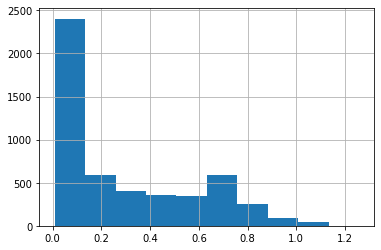

In [214]:
pd.Series(entropy).hist()

In [215]:
print(sum(entropy>1))
print(sum(entropy>0.8))

56
265


In [220]:
sampled_indices = set(
    pd.Series(soft_pred2).groupby(soft_pred2).apply(lambda x: x.index.to_series().sample(300, replace=True, random_state=1)).values
).union(set(
    np.where(new_pred[:, 1] > 0.01)[0]
)).union(set(
    np.where(new_pred[:, 0] > 0.4)[0]
)).union(set(
    np.where(entropy >= 0.75)[0]
))
print(len(sampled_indices))

1049


In [222]:
max(sampled_indices), unlabeled_filtered.shape

(5087, (5088, 28))

In [228]:
unlabeled_filtered.iloc[sorted(sampled_indices)].to_csv('least_confident_samples_20210731.csv')